In [147]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torch.nn.functional as F
import math
from scipy.stats import wasserstein_distance
from sklearn.preprocessing import StandardScaler
from qolmat.diffusion_model  import ImputerDiffusion
from qolmat.model  import TabDDPM, TsDDPM
from diffusion_forecasting import DDPM

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [148]:
from load_data import prepare_data, aggregate_market_data
from dataloader import TimeSeriesDataset

In [149]:
device = torch.device("cuda:0" if torch.cuda.is_available() else torch.device('cpu'))

## Load Data

In [150]:
from_year = "1999"
end_year = "2019"
start_year_test = "2020"

In [151]:
data = aggregate_market_data()
df_reindexed, df_orig, df = prepare_data(data, from_year = from_year, start_year_test = None)

100%|██████████| 141/141 [00:00<00:00, 247.90it/s]


### Preprocess Data

In [152]:
train_df = df_reindexed.loc[:start_year_test]
train_df = train_df.interpolate(method='nearest')
X_train = train_df.to_numpy()
X_train = torch.tensor(X_train, dtype=torch.float32, device=device)

## Hyperparameters

In [153]:
# hyperparameters

# diffusion hyperparameters
timesteps = 50
beta1 = 1e-4
beta2 = 0.02

# network hyperparameters
input_size = 608
context_window = 512
forecast_length = 96
hidden_dim = 7
n_feat = df_reindexed.shape[1] 
save_dir = './weights/'

# training hyperparameters
batch_size = 64
n_epoch = 15
lrate=1e-3

## DDPM

### Models

In [154]:
#model = CustomTransformerTimeSeries(input_size=input_size, n_feat=n_feat, hidden_size=32, num_layers=2, num_heads=2, dropout_prob=0.1)

In [155]:
from models_forecasting import DenoiserTST, ResidualBlockTS
model = DenoiserTST(num_noise_steps = timesteps,
                    dim_input = n_feat ,
                    residual_block = ResidualBlockTS(dim_input = n_feat, dim_embedding = hidden_dim, dim_feedforward = hidden_dim, context_window = context_window, forecast_length = forecast_length),
                    dim_embedding = hidden_dim,
)

In [156]:
#model_qolmat = TsDDPM(num_noise_steps=50,nheads_feature=8,nheads_time=8)

### Training

In [157]:
from transformers import PatchTSTForPrediction
model_tst = PatchTSTForPrediction.from_pretrained("namctin/patchtst_etth1_forecast")
for name, module in model_tst.named_modules():
    print(name)


model
model.scaler
model.scaler.scaler
model.patchifier
model.masking
model.encoder
model.encoder.embedder
model.encoder.embedder.input_embedding
model.encoder.positional_encoder
model.encoder.positional_encoder.positional_dropout
model.encoder.layers
model.encoder.layers.0
model.encoder.layers.0.self_attn
model.encoder.layers.0.self_attn.k_proj
model.encoder.layers.0.self_attn.v_proj
model.encoder.layers.0.self_attn.q_proj
model.encoder.layers.0.self_attn.out_proj
model.encoder.layers.0.dropout_path1
model.encoder.layers.0.norm_sublayer1
model.encoder.layers.0.norm_sublayer1.batchnorm
model.encoder.layers.0.ff
model.encoder.layers.0.ff.0
model.encoder.layers.0.ff.1
model.encoder.layers.0.ff.2
model.encoder.layers.0.ff.3
model.encoder.layers.0.dropout_path3
model.encoder.layers.0.norm_sublayer3
model.encoder.layers.0.norm_sublayer3.batchnorm
model.encoder.layers.1
model.encoder.layers.1.self_attn
model.encoder.layers.1.self_attn.k_proj
model.encoder.layers.1.self_attn.v_proj
model.enc

In [158]:
train_dataset = TimeSeriesDataset(X_train, seq_len=input_size)
train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = False)
optim = torch.optim.Adam(model.parameters(), lr=lrate)

In [159]:
ddpm = DDPM(model = model, 
            optimizer = optim,
            device = device, 
            timesteps = timesteps, 
            beta1 = beta1, 
            beta2 = beta2, 
            n_epoch = n_epoch, 
            batch_size = batch_size, 
            lrate = lrate, 
            save_dir = save_dir,
            context_window=context_window,
            forecast_length=forecast_length)

In [160]:
losses, maes, wasserstein_distances =ddpm.train(train_loader=train_loader)

epoch 0


100%|██████████| 81/81 [01:45<00:00,  1.31s/it]


Loss: 1.3235640246421099, MAE: 1.0327832018956542, Wasserstein Distance: 0.7882548894686985
epoch 1


100%|██████████| 81/81 [01:46<00:00,  1.31s/it]


epoch 2


100%|██████████| 81/81 [01:46<00:00,  1.31s/it]


epoch 3


100%|██████████| 81/81 [01:44<00:00,  1.29s/it]


epoch 4


100%|██████████| 81/81 [01:44<00:00,  1.29s/it]


Loss: 1.263469522818923, MAE: 1.0090188682079315, Wasserstein Distance: 0.97163088357746
epoch 5


100%|██████████| 81/81 [01:59<00:00,  1.47s/it]


epoch 6


100%|██████████| 81/81 [01:59<00:00,  1.48s/it]


epoch 7


100%|██████████| 81/81 [02:04<00:00,  1.53s/it]


epoch 8


100%|██████████| 81/81 [01:58<00:00,  1.46s/it]


Loss: 1.2619757996872067, MAE: 1.0083917761221528, Wasserstein Distance: 0.9589121761683661
epoch 9


100%|██████████| 81/81 [01:50<00:00,  1.36s/it]


epoch 10


100%|██████████| 81/81 [01:48<00:00,  1.34s/it]


epoch 11


100%|██████████| 81/81 [01:49<00:00,  1.36s/it]


epoch 12


100%|██████████| 81/81 [01:48<00:00,  1.34s/it]


Loss: 1.260894775390625, MAE: 1.007937273941934, Wasserstein Distance: 0.9426835793829279
epoch 13


100%|██████████| 81/81 [01:46<00:00,  1.31s/it]


epoch 14


100%|██████████| 81/81 [01:48<00:00,  1.34s/it]

Loss: 1.258301891386509, MAE: 1.0068399608135223, Wasserstein Distance: 0.9359786783000945
saved model at ./weights/model_final.pth


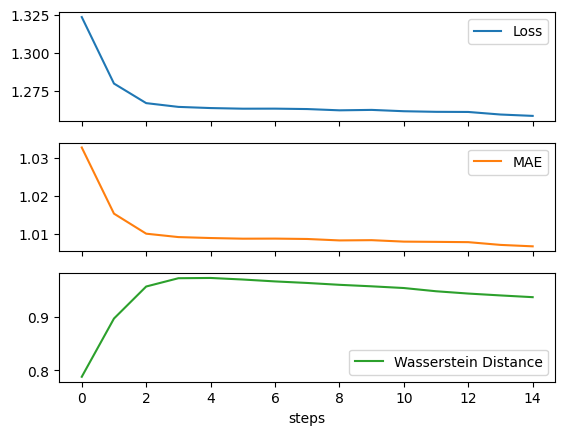

In [161]:
# Convert lists to DataFrame
metrics_df = pd.DataFrame({
    'Loss': losses,
    'MAE': maes,
    'Wasserstein Distance': wasserstein_distances
})

# Plot metrics
metrics_df.plot(subplots=True)
plt.xlabel('steps')
plt.show()

In [162]:
n_sample = X_train.shape[0] // input_size

In [163]:
test_df = df_reindexed.dropna(axis=0).loc[start_year_test:]
test_df = test_df.interpolate(method='nearest')

In [164]:
X_test = test_df.to_numpy()
X_test = torch.tensor(X_test, dtype=torch.float32, device=device)

In [165]:
context = X_test[:context_window]

In [166]:
context = context.unsqueeze(dim=0)

In [167]:
gen_samples, _  = ddpm.sample(context_test= context, dim_input = n_feat, save_rate=20)

In [168]:
context_df = test_df[:context_window]
y_true = test_df[context_window:context_window+forecast_length]

In [169]:
y_pred_df = pd.DataFrame(gen_samples[0].cpu().detach().numpy(), index=y_true.index, columns = test_df.columns)

In [170]:
#concat context and y_true
y_true = test_df

In [199]:
values_orig = y_true.mean(axis=1)
#inserting the starting point to the synthetic data
values_imp = pd.concat([pd.Series(starting_point.mean(axis=1)),y_pred_df.mean(axis=1)])
values_orig = values_orig.cumsum()
values_imp = values_imp.cumsum()
import plotly.graph_objects as go
fig = go.Figure()
fig.add_trace(go.Scatter(x=values_orig.index, y=values_orig, mode='lines', name='original'))
fig.add_trace(go.Scatter(x=values_imp.index, y=values_imp, mode='lines', name='Sampled'))
fig.show()

In [195]:
from plot_results import plot_data
columns = test_df.columns.tolist()
starting_point = y_true[:context_window].cumsum().iloc[-1].to_frame().T
plot_data(y_true, y_pred_df, starting_point, columns)